In [109]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore') 

start = time.perf_counter()

In [110]:
df = pd.read_csv('earl694412-infinite-matchhistory.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 841 entries, 0 to 840
Data columns (total 47 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               841 non-null    object 
 1   SeasonNumber       841 non-null    int64  
 2   SeasonVersion      841 non-null    int64  
 3   Player             841 non-null    object 
 4   MatchId            841 non-null    object 
 5   Map                841 non-null    object 
 6   Category           841 non-null    object 
 7   Playlist           841 non-null    object 
 8   Input              841 non-null    object 
 9   Queue              841 non-null    object 
 10  PreCsr             841 non-null    int64  
 11  PostCsr            841 non-null    int64  
 12  Rank               841 non-null    int64  
 13  WasAtStart         841 non-null    int64  
 14  WasAtEnd           841 non-null    int64  
 15  WasInProgressJoin  841 non-null    int64  
 16  Mmr                2 non-n

In [111]:
df['Date'] = pd.to_datetime(df['Date'])
df['LengthMinutes'] = df['LengthSeconds'] / 60
df.rename(columns={'TotalKills': 'Kills'}, inplace=True)
df['KillsBody'] = df['Kills'] - df['KillsGrenade'] - df['KillsHeadshot'] - df['KillsMelee'] - df['KillsPower']
df['DamageRatio'] = df['DamageDone'] / df['DamageTaken']
df['Damage/Kill'] = df['DamageDone'] / df['Kills']
# Per 10 Min
df['Kills/10Min'] = (df['Kills'] / df['LengthMinutes']) * 10
df['Deaths/10Min'] = (df['Deaths'] / df['LengthMinutes']) * 10
df['Assists/10Min'] = (df['Assists'] / df['LengthMinutes']) * 10
df['Dmg/10Min'] = (df['DamageDone'] / df['LengthMinutes']) * 10
df['DmgT/10Min'] = (df['DamageTaken'] / df['LengthMinutes']) * 10
df['Shots/10Min'] = (df['ShotsFired'] / df['LengthMinutes']) * 10
# Excess
df['ExcessKills'] = df['Kills'] - df['ExpectedKills']
df['ExcessDeaths'] = df['ExpectedDeaths'] - df['Deaths']
# Kill Type
df['BodyPct'] = df['KillsBody'] / df['Kills'] *100
df['MeleePct'] = df['KillsMelee'] / df['Kills'] * 100
df['HSPct'] = df['KillsHeadshot'] / df['Kills'] * 100
df['GrenadePct'] = df['KillsGrenade'] / df['Kills'] * 100
df['PowerPct'] = df['KillsPower'] / df['Kills'] * 100



df = df.drop(['Player', 'MatchId', 'Input', 'Queue', 'Mmr', 'PreCsr', 'PostCsr', 'ShotsFired', 'AssistsEmp',
              'ShotsMissed', 'ShotsLanded', 'Betrayals', 'Suicides', 'WasAtStart', 'WasAtEnd', 'AssistsDriver',
              'Perfects', 'WasInProgressJoin', 'VehicleDestroys', 'VehicleHijacks', 'AssistsCallout',
              'LengthSeconds', 'Rank', 'SeasonNumber', 'SeasonVersion', 'Map'],axis=1)
df = df.drop(['KillsBody','KillsMelee', 'KillsGrenade', 'KillsHeadshot', 'KillsPower'], axis=1)
df = df.drop(['Kills','Deaths', 'Assists', 'DamageDone', 'DamageTaken'], axis=1)
dfR = df[df['Playlist'] == 'Ranked Arena']
dfRR = dfR[dfR['Date']> '2023-01-01']
dfRR = dfRR[dfRR['Outcome'] != 'Draw']
dfRR = dfRR[dfRR['Outcome'] != 'Left']
dfRR['Outcome'] = dfRR['Outcome'].map({'Win': 1, 'Loss': 0})
dfRR = dfRR.drop(['Date', 'Category', 'Playlist'], axis=1)
dfRR = dfRR.dropna()
dfRR.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 582 entries, 140 to 840
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Outcome         582 non-null    int64  
 1   Accuracy        582 non-null    float64
 2   KD              582 non-null    float64
 3   KDA             582 non-null    float64
 4   MaxSpree        582 non-null    int64  
 5   ExpectedKills   582 non-null    float64
 6   ExpectedDeaths  582 non-null    float64
 7   Score           582 non-null    int64  
 8   Medals          582 non-null    int64  
 9   LengthMinutes   582 non-null    float64
 10  DamageRatio     582 non-null    float64
 11  Damage/Kill     582 non-null    float64
 12  Kills/10Min     582 non-null    float64
 13  Deaths/10Min    582 non-null    float64
 14  Assists/10Min   582 non-null    float64
 15  Dmg/10Min       582 non-null    float64
 16  DmgT/10Min      582 non-null    float64
 17  Shots/10Min     582 non-null    f

In [112]:
def cnt(df, col):
    count = df[col].count()
    return count
def sm(df, col):
    sum = df[col].sum()
    return sum
def avg(df, col, val=None):
    avg = round(sm(df, col) / cnt(df, col),val)
    return avg


In [113]:
corr_mtrx = dfRR.corr().abs()
print(corr_mtrx['Outcome'].sort_values(ascending=False))

Outcome           1.000000
Deaths/10Min      0.433900
DmgT/10Min        0.354413
KD                0.315957
KDA               0.285080
ExcessDeaths      0.257714
ExpectedDeaths    0.202335
Damage/Kill       0.187406
Assists/10Min     0.179060
Kills/10Min       0.148299
LengthMinutes     0.130204
DamageRatio       0.124777
MaxSpree          0.116227
Accuracy          0.090455
Score             0.041835
BodyPct           0.040458
Dmg/10Min         0.040125
HSPct             0.034776
ExpectedKills     0.030873
Medals            0.025450
MeleePct          0.015735
GrenadePct        0.014169
ExcessKills       0.012225
Shots/10Min       0.009835
PowerPct          0.003647
Name: Outcome, dtype: float64


In [114]:
# dfRR.hist(bins=15, figsize=(16, 12))
# plt.tight_layout()
# plt.show()

In [115]:
dfRR.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Outcome,582.0,0.546392,0.498271,0.000000,0.000000,1.000000,1.000000,1.000000
Accuracy,582.0,51.823591,5.192714,36.800000,48.560000,51.895000,54.872500,80.560000
KD,582.0,1.276959,0.755203,0.270000,0.860000,1.130000,1.460000,10.000000
KDA,582.0,4.604553,5.588339,-9.660000,0.660000,4.660000,8.000000,31.000000
MaxSpree,582.0,3.972509,1.567506,1.000000,3.000000,4.000000,5.000000,10.000000
ExpectedKills,582.0,14.560137,4.489306,2.000000,11.000000,14.000000,18.000000,32.000000
ExpectedDeaths,582.0,14.420962,4.641329,0.000000,11.000000,14.000000,17.000000,31.000000
Score,582.0,2153.951890,895.738198,250.000000,1452.500000,2047.500000,2710.000000,6625.000000
Medals,582.0,6.429553,3.719191,0.000000,4.000000,6.000000,8.000000,23.000000
LengthMinutes,582.0,10.513345,2.960559,1.483333,8.291667,9.983333,12.695833,21.333333


In [116]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [117]:
# Define features (X) and target variable (y)
X = dfRR.drop('Outcome', axis=1) 
X = round(X,20)
y = dfRR['Outcome'] 

print(f'X Shape: {X.shape}')
print(f'Y Shape: {y.shape}')

X Shape: (582, 24)
Y Shape: (582,)


In [118]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=2)
print(f'X Train Shape: {X_train.shape}')
print(f'X Test Shape: {X_test.shape}')
print(X_train.columns)
print(X_test.info())

X Train Shape: (465, 24)
X Test Shape: (117, 24)
Index(['Accuracy', 'KD', 'KDA', 'MaxSpree', 'ExpectedKills', 'ExpectedDeaths',
       'Score', 'Medals', 'LengthMinutes', 'DamageRatio', 'Damage/Kill',
       'Kills/10Min', 'Deaths/10Min', 'Assists/10Min', 'Dmg/10Min',
       'DmgT/10Min', 'Shots/10Min', 'ExcessKills', 'ExcessDeaths', 'BodyPct',
       'MeleePct', 'HSPct', 'GrenadePct', 'PowerPct'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 117 entries, 767 to 701
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Accuracy        117 non-null    float64
 1   KD              117 non-null    float64
 2   KDA             117 non-null    float64
 3   MaxSpree        117 non-null    int64  
 4   ExpectedKills   117 non-null    float64
 5   ExpectedDeaths  117 non-null    float64
 6   Score           117 non-null    int64  
 7   Medals          117 non-null    int64  
 8   LengthMinutes 

In [119]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler


# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Accuracy', 'ExpectedKills', 'ExpectedDeaths', 'KD', 'KDA', 'MaxSpree',
                                    # 'Deaths', 'Assists', 'Kills', 'DamageDone', 'DamageTaken',
                                    'Score', 'Medals', 'LengthMinutes', 'DamageRatio', 'Damage/Kill',
                                    'Kills/10Min', 'Deaths/10Min', 'Assists/10Min', 'Dmg/10Min',
                                    'DmgT/10Min', 'Shots/10Min', 'ExcessKills', 'ExcessDeaths',
                                    'BodyPct', 'MeleePct', 'HSPct', 'GrenadePct', 'PowerPct'])])

# Create the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit and transform the data
X_train_preprocessed = pipeline.fit_transform(X_train)
X_test_preprocessed = pipeline.transform(X_test)

# X_train_preprocessed.to_csv('X_train_preprocessed.csv')
# X_test_preprocessed.to_csv('X_test_preprocessed.csv')

print(f'X Train Processed Shape: {X_train_preprocessed.shape}')
print(f'X Train Shape: {X_train.shape}')
print(f'X Test Processed Shape: {X_test_preprocessed.shape}')

X Train Processed Shape: (465, 24)
X Train Shape: (465, 24)
X Test Processed Shape: (117, 24)


In [120]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, log_loss, classification_report, confusion_matrix
MSE_Histmean = mean_squared_error(y_test,np.full(y_test.shape,np.mean(y_train)))

def ResultsOut(model):
  y_pred = model.predict(X_test_preprocessed)
  # Calculate regression metrics
  acc = model.score(X_test_preprocessed, y_test)
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  rmse = mean_squared_error(y_test, y_pred, squared=False)
  r2 = r2_score(y_test, y_pred)
  oosr2 = 1-mean_squared_error(y_test,y_pred)/MSE_Histmean
  ll = log_loss(y_test,y_pred)
  clRep = classification_report(y_test, y_pred)
  confM = confusion_matrix(y_test, y_pred)

  # Print the metrics with newline characters
  print("Acc: {:.3f}".format(acc))
  print("MAE: {:.2f}".format(mae))
  print("MSE: {:.2f}".format(mse))
  print("RMSE: {:.2f}".format(rmse))
  print("R^2 Score: {:.2f}".format(r2))
  print("OOS R^2 Score: {:.2f}".format(oosr2))
  print("Log Loss: {:.2f}".format(ll))
  print('---------------------------------------------------------')
  print(clRep)
  print('---------------------------------------------------------') 
  # print(confM)
  # print('---------------------------------------------------------') 
  return ''

def paramResults(mod):
    results_df = pd.DataFrame({'param': mod.cv_results_["params"], 'Accuracy': mod.cv_results_["mean_test_score"]})

    # Splitting the 'param' column into separate columns
    params_df = pd.DataFrame(results_df['param'].to_list())
    params_df.columns = [f"{col}_param" for col in params_df.columns]

    # Concatenating the new columns with the 'Accuracy' column
    results_df = pd.concat([params_df, results_df['Accuracy']], axis=1)

    # Displaying the updated DataFrame
    print(results_df)
    return ''

def featImport(mod):
    feat_importances = pd.DataFrame(mod.best_estimator_.feature_importances_[:24], index=X_train.columns, columns=["Importance"])
    feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
    feat_importances.plot(kind='bar', figsize=(8,6))
    plt.show()

def coefs(mod):
  # Get the coefficients
  coefficients = mod.coef_[0]

  # Create a dictionary with feature names and their corresponding coefficients
  feature_coefficients = dict(zip(X_train.columns, coefficients))

  # Sort features by coefficients in descending order
  sorted_features = sorted(feature_coefficients.items(), key=lambda x: abs(x[1]), reverse=True)

  # Print or analyze the top 5 sorted feature coefficients
  print("Top 5 Sorted Feature Coefficients:")
  for feature, coefficient in sorted_features[:5]:
      print(f"{feature}: {coefficient:.2f}")


## Logistic Regression

In [121]:
# Unregularized Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

logreg = LogisticRegression(penalty=None)
logreg.fit(X_train_preprocessed, y_train)

print(f'Unregularized Logistic Regression Accuracy: {logreg.score(X_test_preprocessed, y_test)}')
print(ResultsOut(logreg))
print(coefs(logreg))

Unregularized Logistic Regression Accuracy: 0.8205128205128205
Acc: 0.821
MAE: 0.18
MSE: 0.18
RMSE: 0.42
R^2 Score: 0.28
OOS R^2 Score: 0.28
Log Loss: 6.47
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.77      0.80        53
           1       0.82      0.86      0.84        64

    accuracy                           0.82       117
   macro avg       0.82      0.82      0.82       117
weighted avg       0.82      0.82      0.82       117

---------------------------------------------------------

Top 5 Sorted Feature Coefficients:
Deaths/10Min: -3.54
KD: 3.33
ExcessDeaths: -1.92
KDA: -1.86
LengthMinutes: -1.36
None


## Ridge

In [122]:
# Ridge
# Need to find best params for param grid

C_grid = [10**-3,10**-2,10**-1,10**0,10**1,10**2]

param_grid={'C':C_grid}
ridge_cv = GridSearchCV(LogisticRegression(penalty='l2',solver='saga'),
                                          param_grid=param_grid,cv=5)
ridge_cv.fit(X_train_preprocessed,y_train)

print(ridge_cv.best_estimator_)
print(f'Ridge Accuracy: {ridge_cv.score(X_test_preprocessed, y_test)}')
print(paramResults(ridge_cv))
print(ResultsOut(ridge_cv))
print(coefs(ridge_cv.best_estimator_))


LogisticRegression(C=10, solver='saga')
Ridge Accuracy: 0.8034188034188035
   C_param  Accuracy
0    0.001  0.638710
1    0.010  0.703226
2    0.100  0.774194
3    1.000  0.784946
4   10.000  0.789247
5  100.000  0.789247

Acc: 0.803
MAE: 0.20
MSE: 0.20
RMSE: 0.44
R^2 Score: 0.21
OOS R^2 Score: 0.21
Log Loss: 7.09
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.77      0.78        53
           1       0.82      0.83      0.82        64

    accuracy                           0.80       117
   macro avg       0.80      0.80      0.80       117
weighted avg       0.80      0.80      0.80       117

---------------------------------------------------------

Top 5 Sorted Feature Coefficients:
Deaths/10Min: -2.07
KDA: -1.60
ExcessKills: -1.58
KD: 1.49
ExcessDeaths: -1.45
None


## Lasso

In [123]:
# Lasso

param_grid={'C':C_grid}
lasso_cv = GridSearchCV(LogisticRegression(penalty='l1',solver='saga'),
                                          param_grid=param_grid,cv=5)
lasso_cv.fit(X_train_preprocessed,y_train)

print(lasso_cv.best_estimator_)
print(f'Lasso Accuracy: {lasso_cv.score(X_test_preprocessed, y_test)}')
print(paramResults(lasso_cv))
print(ResultsOut(lasso_cv))
print(coefs(lasso_cv.best_estimator_))

LogisticRegression(C=100, penalty='l1', solver='saga')
Lasso Accuracy: 0.8034188034188035
   C_param  Accuracy
0    0.001  0.546237
1    0.010  0.546237
2    0.100  0.711828
3    1.000  0.778495
4   10.000  0.787097
5  100.000  0.789247

Acc: 0.803
MAE: 0.20
MSE: 0.20
RMSE: 0.44
R^2 Score: 0.21
OOS R^2 Score: 0.21
Log Loss: 7.09
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.77      0.78        53
           1       0.82      0.83      0.82        64

    accuracy                           0.80       117
   macro avg       0.80      0.80      0.80       117
weighted avg       0.80      0.80      0.80       117

---------------------------------------------------------

Top 5 Sorted Feature Coefficients:
Deaths/10Min: -2.11
KDA: -1.62
ExcessKills: -1.59
KD: 1.52
ExcessDeaths: -1.47
None


## ElasticNet

In [124]:
# ElasticNet

param_grid2={'C':C_grid,'l1_ratio':[.25, .5, .75]}

elastic_cv = GridSearchCV(LogisticRegression(penalty='elasticnet',solver='saga'),
                                            param_grid=param_grid2,cv=5)
elastic_cv.fit(X_train_preprocessed,y_train)

print(elastic_cv.best_estimator_)
print(f'ElasticNet Accuracy: {elastic_cv.score(X_test_preprocessed, y_test)}')
print(paramResults(elastic_cv))
print(ResultsOut(elastic_cv))
print(coefs(elastic_cv.best_estimator_))



LogisticRegression(C=10, l1_ratio=0.25, penalty='elasticnet', solver='saga')
ElasticNet Accuracy: 0.8034188034188035
    C_param  l1_ratio_param  Accuracy
0     0.001            0.25  0.546237
1     0.001            0.50  0.546237
2     0.001            0.75  0.546237
3     0.010            0.25  0.679570
4     0.010            0.50  0.632258
5     0.010            0.75  0.546237
6     0.100            0.25  0.759140
7     0.100            0.50  0.726882
8     0.100            0.75  0.722581
9     1.000            0.25  0.780645
10    1.000            0.50  0.782796
11    1.000            0.75  0.780645
12   10.000            0.25  0.789247
13   10.000            0.50  0.789247
14   10.000            0.75  0.787097
15  100.000            0.25  0.789247
16  100.000            0.50  0.789247
17  100.000            0.75  0.789247

Acc: 0.803
MAE: 0.20
MSE: 0.20
RMSE: 0.44
R^2 Score: 0.21
OOS R^2 Score: 0.21
Log Loss: 7.09
---------------------------------------------------------
         

## K-Nearest Neighbours

In [125]:
# K-Nearest Neighbours
from sklearn.neighbors import KNeighborsClassifier

k_values = list(range(1,50,3))
param_grid = {'n_neighbors': k_values}

knn_cv = GridSearchCV(KNeighborsClassifier(),param_grid,cv=5,n_jobs=-1)
knn_cv.fit(X_train_preprocessed,y_train)

print(knn_cv.best_estimator_)
print(f'K-Nearest Neighbors Accuracy: {knn_cv.score(X_test_preprocessed, y_test)}')
knn_cv.cv_results_
print(paramResults(knn_cv))
print(ResultsOut(knn_cv))



KNeighborsClassifier(n_neighbors=7)
K-Nearest Neighbors Accuracy: 0.6581196581196581
    n_neighbors_param  Accuracy
0                   1  0.645161
1                   4  0.647312
2                   7  0.668817
3                  10  0.643011
4                  13  0.664516
5                  16  0.649462
6                  19  0.653763
7                  22  0.630108
8                  25  0.632258
9                  28  0.638710
10                 31  0.640860
11                 34  0.647312
12                 37  0.647312
13                 40  0.638710
14                 43  0.645161
15                 46  0.643011
16                 49  0.649462

Acc: 0.658
MAE: 0.34
MSE: 0.34
RMSE: 0.58
R^2 Score: -0.38
OOS R^2 Score: -0.38
Log Loss: 12.32
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.61      0.66      0.64        53
           1       0.70      0.66      0.68        64

    accuracy        

## Random Forest

In [126]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {'n_estimators': [100,300,500],'max_depth': [10, 15, 20]}
rf_cv = GridSearchCV(estimator=RandomForestClassifier(random_state=69,max_features='sqrt'),
                                                     cv=5, param_grid=param_grid_rf,n_jobs=-1)
rf_cv.fit(X_train_preprocessed, y_train)

print(rf_cv.best_estimator_)
print(f'Random Forest Accuracy: {rf_cv.score(X_test_preprocessed, y_test)}')
rf_cv.cv_results_
paramResults(rf_cv)

RandomForestClassifier(max_depth=15, n_estimators=300, random_state=69)
Random Forest Accuracy: 0.7435897435897436
   max_depth_param  n_estimators_param  Accuracy
0               10                 100  0.686022
1               10                 300  0.688172
2               10                 500  0.692473
3               15                 100  0.688172
4               15                 300  0.696774
5               15                 500  0.696774
6               20                 100  0.694624
7               20                 300  0.692473
8               20                 500  0.696774


''

In [127]:
ResultsOut(rf_cv)

Acc: 0.744
MAE: 0.26
MSE: 0.26
RMSE: 0.51
R^2 Score: -0.03
OOS R^2 Score: -0.03
Log Loss: 9.24
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.72      0.72      0.72        53
           1       0.77      0.77      0.77        64

    accuracy                           0.74       117
   macro avg       0.74      0.74      0.74       117
weighted avg       0.74      0.74      0.74       117

---------------------------------------------------------


''

<AxesSubplot: >

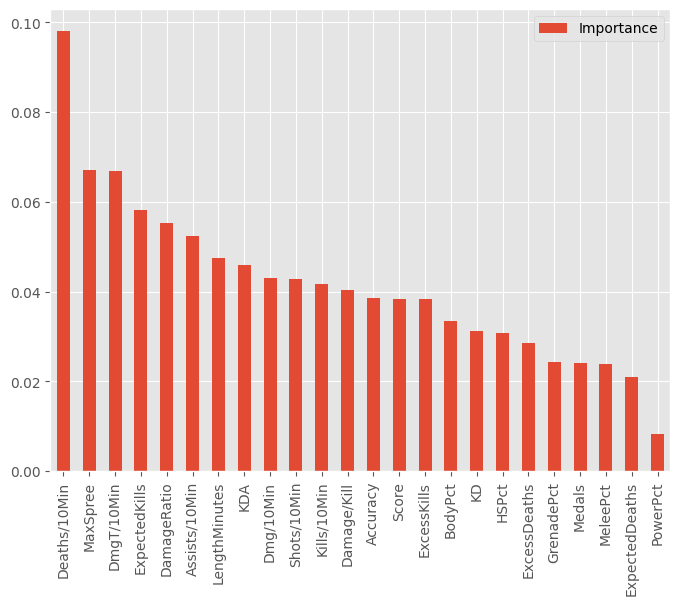

In [128]:
feat_importances = pd.DataFrame(rf_cv.best_estimator_.feature_importances_[:30], index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6))

## Gradient Boosted Trees

In [129]:
# Gradient Boosted Trees
from sklearn.ensemble import GradientBoostingClassifier

param_grid_gbrt = {'n_estimators': [100,300,500],'learning_rate': [0.01,0.1],'max_depth': [2,4,6], 'subsample': [0.5,0.6,0.8,1]}
GBRT = GridSearchCV(estimator=GradientBoostingClassifier(random_state=69),
                    cv=5, param_grid=param_grid_gbrt,n_jobs=-1)
GBRT.fit(X_train_preprocessed, y_train)

print(GBRT.best_estimator_)
print(f'Gradient Boosed Trees Accuracy: {GBRT.score(X_test_preprocessed, y_test)}')
GBRT.cv_results_
paramResults(GBRT)

GradientBoostingClassifier(learning_rate=0.01, max_depth=4, n_estimators=300,
                           random_state=69, subsample=0.6)
Gradient Boosed Trees Accuracy: 0.7521367521367521
    learning_rate_param  max_depth_param  n_estimators_param  subsample_param  \
0                  0.01                2                 100              0.5   
1                  0.01                2                 100              0.6   
2                  0.01                2                 100              0.8   
3                  0.01                2                 100              1.0   
4                  0.01                2                 300              0.5   
..                  ...              ...                 ...              ...   
67                 0.10                6                 300              1.0   
68                 0.10                6                 500              0.5   
69                 0.10                6                 500              0.6   
70

''

In [130]:
ResultsOut(GBRT)

Acc: 0.752
MAE: 0.25
MSE: 0.25
RMSE: 0.50
R^2 Score: -0.00
OOS R^2 Score: -0.00
Log Loss: 8.93
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.73      0.72      0.72        53
           1       0.77      0.78      0.78        64

    accuracy                           0.75       117
   macro avg       0.75      0.75      0.75       117
weighted avg       0.75      0.75      0.75       117

---------------------------------------------------------


''

<AxesSubplot: >

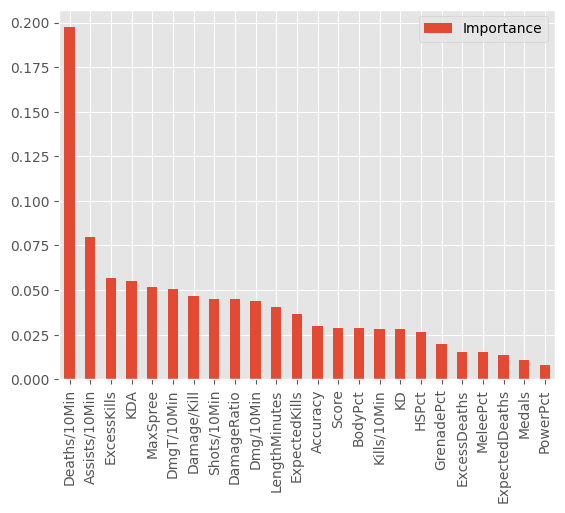

In [131]:
feat_importances = pd.DataFrame(GBRT.best_estimator_.feature_importances_[:30], index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar')

## XGBoost

In [132]:
from xgboost import XGBClassifier

param_grid_xgb = {'n_estimators': [400,450,475,500],'learning_rate': [0.001,0.01,0.1,0.25],'max_depth': [1,2,3,4,5]}
XGB = GridSearchCV(estimator=XGBClassifier(random_state=69), cv=5, param_grid=param_grid_xgb,n_jobs=-1)
XGB.fit(X_train_preprocessed, y_train)

print(XGB.best_estimator_)
print(f'XGBoost Accuracy: {XGB.score(X_test_preprocessed, y_test)}')
paramResults(XGB)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=69, ...)
XGBoost Accuracy: 0.7094017094017094
    learning_rate_param  max_depth_param  n_estimators_param  Accuracy
0                 0.001                1                 400  0.670968
1                 0.001                1                 450  0.670968
2 

''

In [133]:
ResultsOut(XGB)

Acc: 0.709
MAE: 0.29
MSE: 0.29
RMSE: 0.54
R^2 Score: -0.17
OOS R^2 Score: -0.17
Log Loss: 10.47
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.68      0.68      0.68        53
           1       0.73      0.73      0.73        64

    accuracy                           0.71       117
   macro avg       0.71      0.71      0.71       117
weighted avg       0.71      0.71      0.71       117

---------------------------------------------------------


''

<AxesSubplot: >

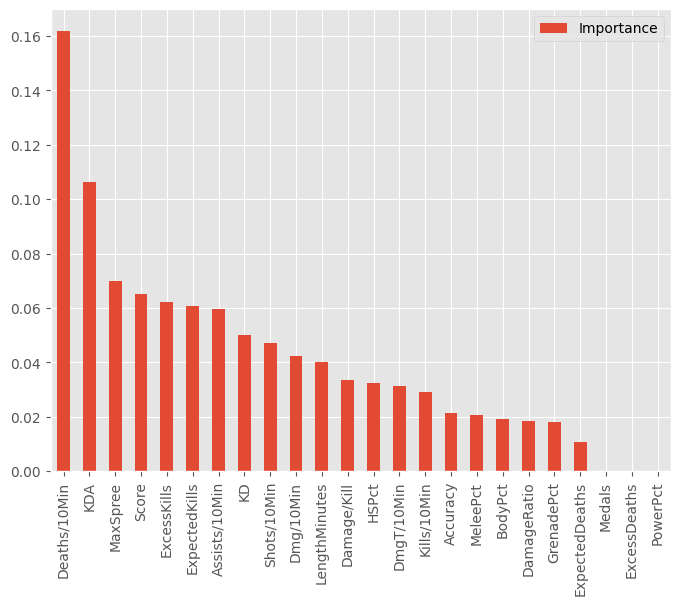

In [134]:
feat_importances = pd.DataFrame(XGB.best_estimator_.feature_importances_[:32], index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6))

## Neural Net

In [136]:
from sklearn.neural_network import MLPClassifier

param_grid_nn = {'activation': ['identity', 'logistic', 'tanh', 'relu'], 'solver': ['lbfgs', 'sgd', 'adam'],
                'learning_rate': ['constant', 'invscaling', 'adaptive'], 'alpha': [0.0001, 0.001, 0.01, 0.1, 1]}
nn = GridSearchCV(estimator=MLPClassifier(random_state=61), cv=5, param_grid=param_grid_nn, n_jobs=-1)

nn.fit(X_train_preprocessed, y_train)
print(nn)
print(f'Neural Net Accuracy: {nn.score(X_test_preprocessed, y_test)}')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

GridSearchCV(cv=5, estimator=MLPClassifier(random_state=61), n_jobs=-1,
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
                         'learning_rate': ['constant', 'invscaling',
                                           'adaptive'],
                         'solver': ['lbfgs', 'sgd', 'adam']})
Neural Net Accuracy: 0.811965811965812


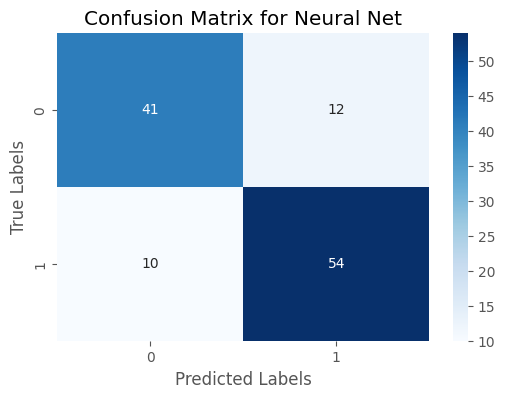

The confusion matrix shows the true positive, false negative, false positive, and true negative values, helping to evaluate the performance of a classification model.


<AxesSubplot: >

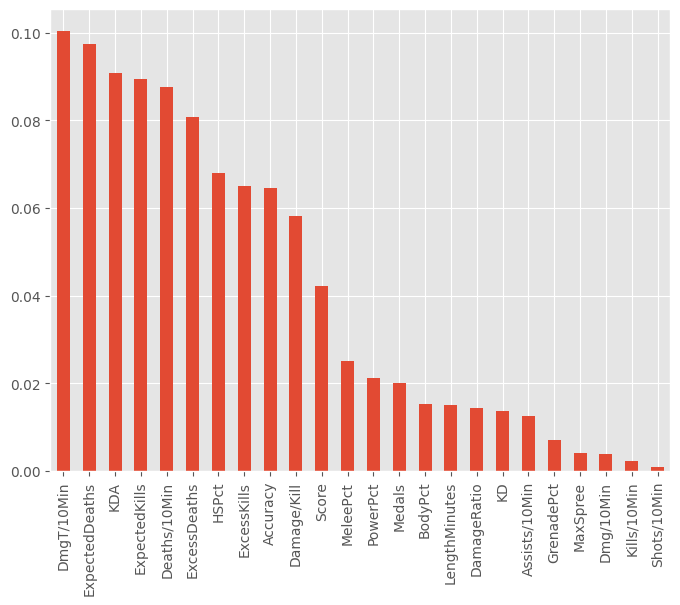

In [138]:
from sklearn.metrics import confusion_matrix
# Generate confusion matrix for the Neural Net
conf_matrix = confusion_matrix(y_test, nn.predict(X_test_preprocessed))
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Neural Net')
plt.show()

print("The confusion matrix shows the true positive, false negative, false positive, and true negative values, helping to evaluate the performance of a classification model.")
feat_importances_nn = pd.DataFrame(nn.best_estimator_.coefs_[0].flatten()[:24], index=X_train.columns, columns=["Importance"])
feat_importances_nn = feat_importances_nn.abs().sum(axis=1)
feat_importances_nn = feat_importances_nn / feat_importances_nn.sum()
feat_importances_nn = feat_importances_nn.sort_values(ascending=False)[:24]
feat_importances_nn.plot(kind='bar', figsize=(8,6))

,Model,ACC,MAE,MSE,RMSE,R2,OOS R2,Log Loss
0,Logistic Regression,0.821,0.179,0.179,0.424,0.276,0.276,6.469
1,NeuralNet,0.812,0.188,0.188,0.434,0.241,0.241,6.777
2,Ridge,0.803,0.197,0.197,0.443,0.207,0.207,7.086
3,Lasso,0.803,0.197,0.197,0.443,0.207,0.207,7.086
4,ElasticNet,0.803,0.197,0.197,0.443,0.207,0.207,7.086
5,Gradient Boosted Trees,0.752,0.248,0.248,0.498,-0.000,-0.000,8.934
6,Random Forest,0.744,0.256,0.256,0.506,-0.035,-0.035,9.242
7,XGBoost,0.709,0.291,0.291,0.539,-0.173,-0.173,10.474
8,K-Nearest Neighbors,0.658,0.342,0.342,0.585,-0.380,-0.380,12.323


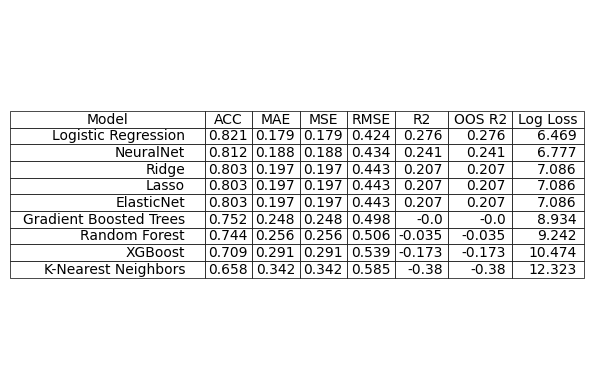

In [139]:
modelss = [logreg,ridge_cv,lasso_cv,elastic_cv,knn_cv,rf_cv,GBRT,XGB,nn]
model_namess = ['Logistic Regression', 'Ridge', 'Lasso', 'ElasticNet',
              'K-Nearest Neighbors', 'Random Forest', 'Gradient Boosted Trees', 'XGBoost', 'NeuralNet']
def saveResults(models, model_names):
    # Initialize an empty dataframe to store the metrics
    metrics_df = pd.DataFrame(columns=['Model', 'ACC' ,'MAE', 'MSE', 'RMSE', 'R2', 'OOS R2', 'Log Loss'])
    
    # Loop through each model and calculate the metrics
    for i, model in enumerate(models):
        # Generate predictions on the test set
        y_pred = model.predict(X_test_preprocessed)
        
        # Calculate regression metrics
        acc = round(model.score(X_test_preprocessed, y_test),3)
        mae = round(mean_absolute_error(y_test, y_pred),3)
        mse = round(mean_squared_error(y_test, y_pred),3)
        rmse = round(mean_squared_error(y_test, y_pred, squared=False),3)
        r2 = round(r2_score(y_test, y_pred),3)
        oosr2 = round(1-mean_squared_error(y_test,y_pred)/MSE_Histmean,3)
        ll = round(log_loss(y_test,y_pred),3)
        
        # Add metrics to the dataframe
        metrics_df.loc[i] = [model_names[i],acc, mae, mse, rmse, r2, oosr2, ll]
    
    metrics_df = metrics_df.sort_values('ACC', ascending=False).reset_index(drop=True)

    fig, ax = plt.subplots()
    table = ax.table(cellText=metrics_df.values, colLabels=metrics_df.columns,
                     cellLoc='right', loc='center')
    table.auto_set_font_size(True)
    table.auto_set_column_width(col=list(range(len(metrics_df.columns))))
    ax.axis('off')
    plt.savefig('ModelResults0210.png', dpi=300, bbox_inches='tight')
    
    return metrics_df

saveResults(modelss,model_namess)


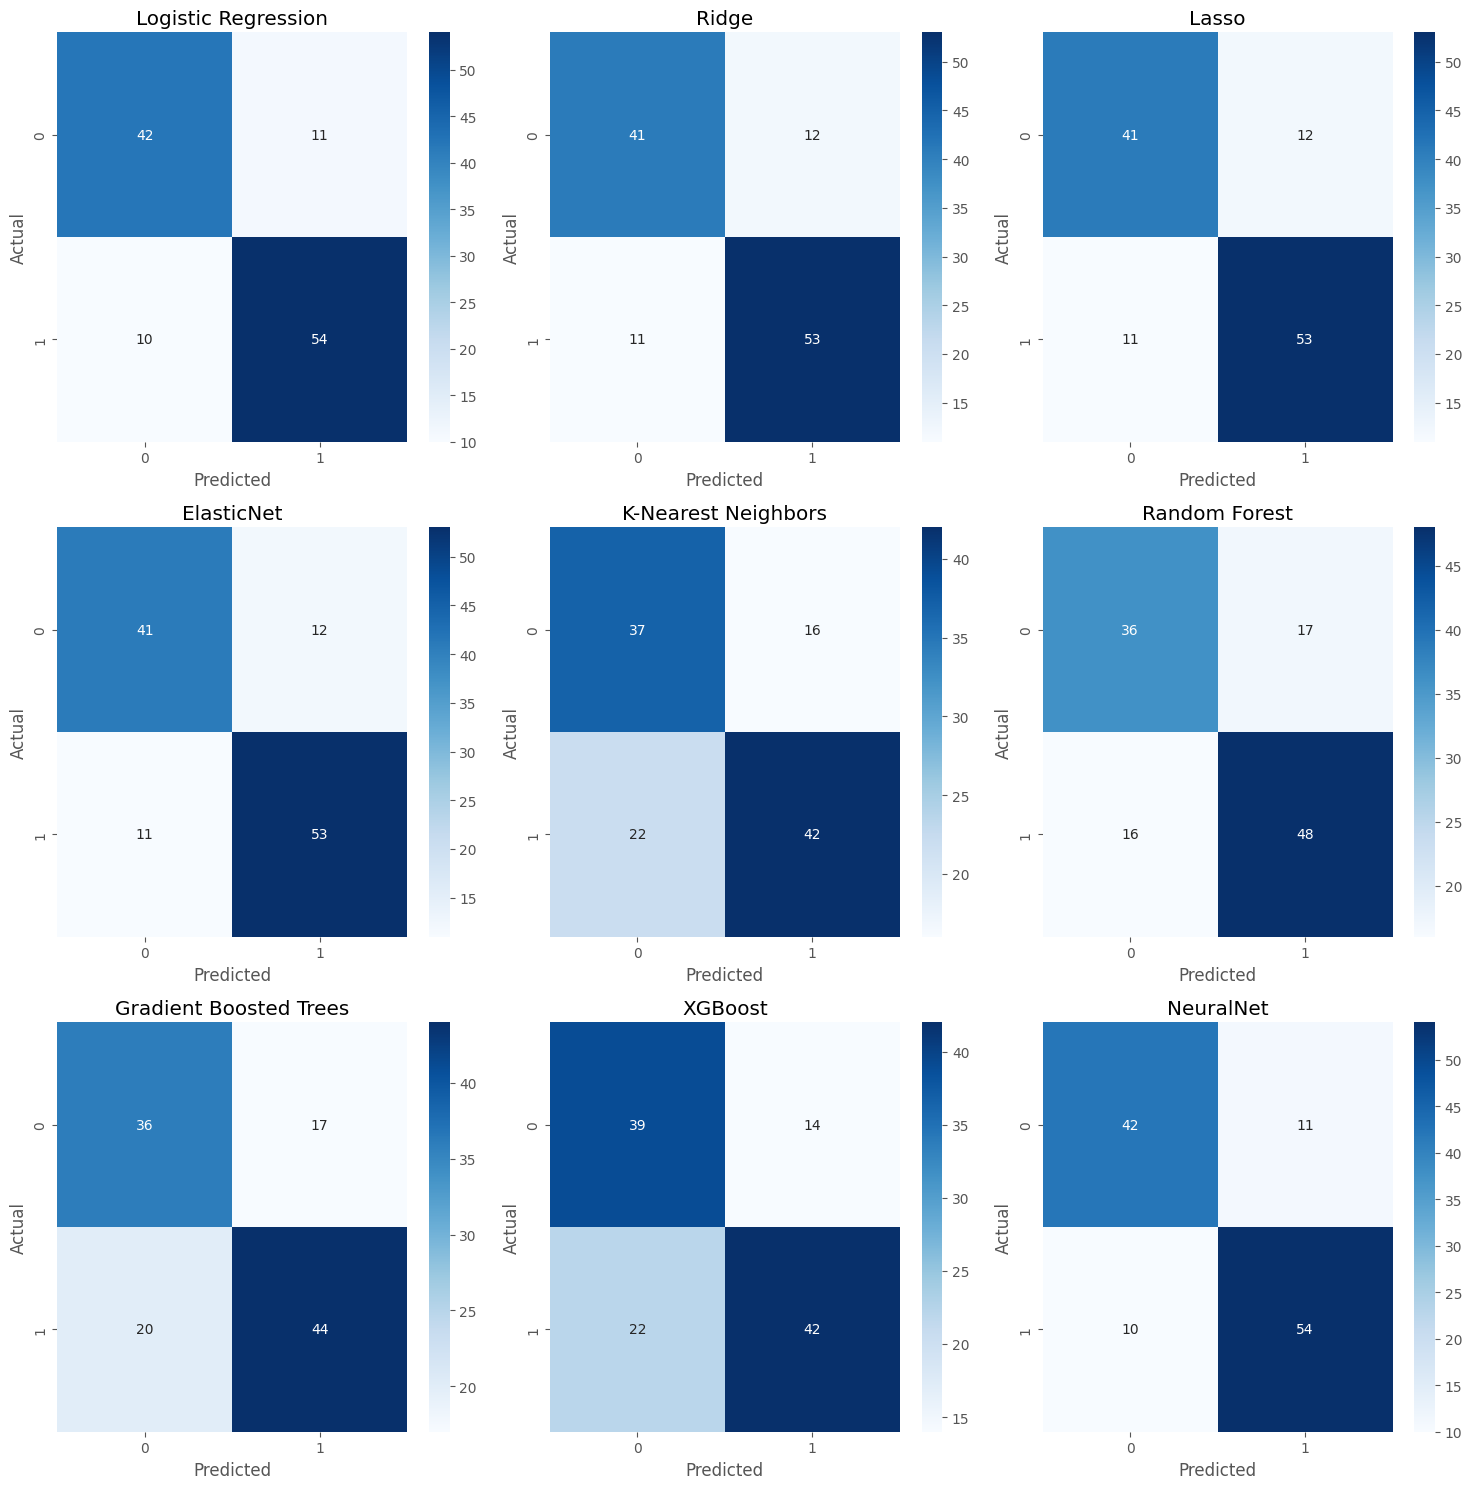

In [ ]:
# Assuming X_test_preprocessed and y_test are your test data
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for i, (model, model_name) in enumerate(zip(modelss, model_namess)):
    y_pred = model.predict(X_test_preprocessed)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axs[i//3, i%3])
    axs[i//3, i%3].set_title(model_name)
    axs[i//3, i%3].set_xlabel('Predicted')
    axs[i//3, i%3].set_ylabel('Actual')

plt.tight_layout()
plt.savefig('Plots/ConfusionMatrixMultigraph.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
print(f'Runtime: {round(time.perf_counter() - start,2)}s')

Runtime: 81.12s


In [ ]:
X_trainp_df = pd.DataFrame(X_train_preprocessed, columns=X_train.columns)
round(X_trainp_df.describe().transpose(),3).sort_values(by='max',ascending=False)

,count,mean,std,min,25%,50%,75%,max
DamageRatio,465.0,-0.0,1.001,-0.574,-0.249,-0.074,0.100,20.523
KD,465.0,-0.0,1.001,-1.275,-0.546,-0.212,0.245,10.750
Damage/Kill,465.0,-0.0,1.001,-1.962,-0.653,-0.212,0.395,6.786
Shots/10Min,465.0,0.0,1.001,-3.112,-0.608,0.023,0.597,6.118
PowerPct,465.0,-0.0,1.001,-0.363,-0.363,-0.363,-0.363,5.605
Score,465.0,0.0,1.001,-2.157,-0.789,-0.128,0.613,5.049
KDA,465.0,0.0,1.001,-2.527,-0.706,-0.000,0.647,4.648
Assists,465.0,0.0,1.001,-1.766,-0.594,-0.125,0.579,4.566
Medals,465.0,0.0,1.001,-1.720,-0.646,-0.109,0.428,4.454
Kills,465.0,0.0,1.001,-2.199,-0.748,-0.103,0.542,4.089
